<a href="https://colab.research.google.com/github/AFAgarap/dnn-trust/blob/master/notebooks/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/SeldonIO/alibi
!mv alibi/alibi/confidence/trustscore.py trustscore.py
!pip install --quiet tensorflow-gpu==2.0.0-beta1

In [0]:
from __future__ import absolute_import, division, print_function

__version__ = '1.0.0'

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from trustscore import TrustScore
assert tf.__version__.startswith('2')

In [0]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0], True
)

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
BATCH_SIZE = 512
SHUFFLE_BUFFER_SIZE = 1000
WIDTH = 32
HEIGHT = 32
NUM_CHANNELS = 3

In [0]:
def augment(image, label):
  image = tf.image.resize_with_crop_or_pad(
      image, HEIGHT + 8, WIDTH + 8)
  image = tf.image.random_crop(image, [HEIGHT, WIDTH, NUM_CHANNELS])
  image = tf.image.random_flip_left_right(image)
  return image, label

In [0]:
cifar_train, cifar_test = tf.keras.datasets.cifar10.load_data()

train_features, train_labels = cifar_train
test_features, test_labels = cifar_test

train_features = train_features.astype('float32') / 255.
test_features = test_features.astype('float32') / 255.

test_features = test_features.reshape(-1, 3072)

validation_features, test_features, validation_labels, test_labels = \
train_test_split(test_features,
                 test_labels,
                 test_size=0.50,
                 stratify=test_labels)

validation_features = validation_features.reshape(-1, 32, 32, 3)
test_features = test_features.reshape(-1, 32, 32, 3)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_features, train_labels)
)
train_dataset = train_dataset.map(augment)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, True)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (validation_features, validation_labels)
)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_features, test_labels)
)
test_dataset = test_dataset.batch(BATCH_SIZE)

W0826 13:09:52.724411 140018468902784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
IMAGE_SHAPE = (HEIGHT, WIDTH, NUM_CHANNELS)

base_model = tf.keras.applications.VGG16(input_shape=IMAGE_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [9]:
feature_batch = base_model(train_features[:BATCH_SIZE])
print(feature_batch.shape)

(512, 1, 1, 512)


In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch)

tf.Tensor(
[[0.02579119 0.05269577 0.3237086  ... 0.04586973 0.19044448 0.02524837]
 [0.03379135 0.02078396 0.3123097  ... 0.05897397 0.18059945 0.0569054 ]
 [0.02484503 0.03765731 0.397765   ... 0.02783872 0.14869481 0.04520175]
 ...
 [0.01924303 0.04616678 0.24000108 ... 0.04854652 0.17080548 0.08402342]
 [0.01901378 0.04443201 0.42998996 ... 0.02762174 0.18051642 0.05332911]
 [0.02539412 0.02681334 0.3900619  ... 0.03025099 0.12463763 0.04385421]], shape=(512, 10), dtype=float32)


In [0]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [0]:
learning_rate = 1e-4
model.compile(optimizer=tf.optimizers.RMSprop(learning_rate),
              loss=tf.losses.sparse_categorical_crossentropy,
              metrics=['sparse_categorical_accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________


In [15]:
epochs = 100

validation_steps = 20

loss_0, accuracy_0 = model.evaluate(validation_dataset, steps=validation_steps)

10/20 [==============>...............] - ETA: 2s - loss: 2.6713 - sparse_categorical_accuracy: 0.1110

W0826 13:10:27.954002 140018468902784 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


In [16]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/100
97/97 [==============================] - 25s 258ms/step - loss: 1.9124 - sparse_categorical_accuracy: 0.3115 - val_loss: 1.5494 - val_sparse_categorical_accuracy: 0.4220
Epoch 2/100
97/97 [==============================] - 20s 207ms/step - loss: 1.2537 - sparse_categorical_accuracy: 0.5672 - val_loss: 0.9263 - val_sparse_categorical_accuracy: 0.6786
Epoch 3/100
97/97 [==============================] - 20s 211ms/step - loss: 0.9719 - sparse_categorical_accuracy: 0.6659 - val_loss: 0.8603 - val_sparse_categorical_accuracy: 0.7032
Epoch 4/100
97/97 [==============================] - 21s 212ms/step - loss: 0.8167 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.8289 - val_sparse_categorical_accuracy: 0.7214
Epoch 5/100
97/97 [==============================] - 21s 217ms/step - loss: 0.7017 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.6789 - val_sparse_categorical_accuracy: 0.7742
Epoch 6/100
97/97 [==============================] - 21s 218ms/step - loss: 0.6201 - spars

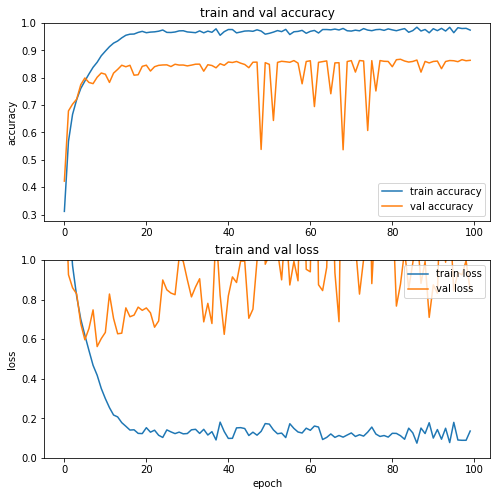

In [17]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='train accuracy')
plt.plot(val_acc, label='val accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('train and val accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.ylim([0, 1.0])
plt.title('train and val loss')
plt.xlabel('epoch')
plt.show()

In [18]:
score = model.evaluate(test_dataset)

10/10 [==============================] - 1s 68ms/step - loss: 0.8829 - sparse_categorical_accuracy: 0.8538


In [19]:
print('Test accuracy : {}'.format(score[1]))

Test accuracy : 0.8537999987602234


In [0]:
model.save_weights(filepath='vgg16/cifar10/1', save_format='tf')

In [21]:
!zip -r vgg16-cifar10.zip vgg16/

  adding: vgg16/ (stored 0%)
  adding: vgg16/cifar10/ (stored 0%)
  adding: vgg16/cifar10/1.index (deflated 75%)
  adding: vgg16/cifar10/1.data-00000-of-00002 (deflated 87%)
  adding: vgg16/cifar10/checkpoint (deflated 34%)
  adding: vgg16/cifar10/1.data-00001-of-00002 (deflated 13%)


In [22]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model_file = drive.CreateFile({'title' : 'vgg16-cifar10.zip'})
model_file.SetContentFile('vgg16-cifar10.zip')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

W0826 13:50:19.587476 140018468902784 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

GoogleDriveFile({'id': '1gSm-LDR3z19tnQq72AakOygF2GRsS_MO'})